In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import pydicom

# from tensorflow.keras.preprocessing.image import ImageDataGenerator

c:\projects\python\venv_test\lib\site-packages\tensorflow\python\keras\engine\training_arrays_v1.py:37: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.19.5)
  from scipy.sparse import issparse  # pylint: disable=g-import-not-at-top


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
train_df = pd.read_csv('train.csv')
label_coords_df = pd.read_csv('train_label_coordinates.csv')

print(train_df.shape)
print(label_coords_df.shape)

(1975, 26)
(48692, 7)


In [4]:
train_df.head(30)

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,left_neural_foraminal_narrowing_l5_s1,right_neural_foraminal_narrowing_l1_l2,right_neural_foraminal_narrowing_l2_l3,right_neural_foraminal_narrowing_l3_l4,right_neural_foraminal_narrowing_l4_l5,right_neural_foraminal_narrowing_l5_s1,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild
5,11340341,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild
6,11943292,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
7,13317052,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate
8,22191399,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Moderate
9,26342422,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild


In [5]:
# melt the DataFrame to long format
train_labels_long = train_df.melt(
    id_vars=['study_id'],
    var_name='condition_level',
    value_name='severity'
)

In [6]:
train_labels_long.head()

,study_id,condition_level,severity
0,4003253,spinal_canal_stenosis_l1_l2,Normal/Mild
1,4646740,spinal_canal_stenosis_l1_l2,Normal/Mild
2,7143189,spinal_canal_stenosis_l1_l2,Normal/Mild
3,8785691,spinal_canal_stenosis_l1_l2,Normal/Mild
4,10728036,spinal_canal_stenosis_l1_l2,Normal/Mild


In [7]:
# split 'condition_level' into 'condition' and 'level'
condition_level_split = train_labels_long['condition_level'].str.rsplit('_', n=2, expand=True)

In [8]:
train_labels_long['condition'] = condition_level_split[0]
train_labels_long['level'] = condition_level_split[1] + '_' + condition_level_split[2]

In [9]:
train_labels_long.head()

,study_id,condition_level,severity,condition,level
0,4003253,spinal_canal_stenosis_l1_l2,Normal/Mild,spinal_canal_stenosis,l1_l2
1,4646740,spinal_canal_stenosis_l1_l2,Normal/Mild,spinal_canal_stenosis,l1_l2
2,7143189,spinal_canal_stenosis_l1_l2,Normal/Mild,spinal_canal_stenosis,l1_l2
3,8785691,spinal_canal_stenosis_l1_l2,Normal/Mild,spinal_canal_stenosis,l1_l2
4,10728036,spinal_canal_stenosis_l1_l2,Normal/Mild,spinal_canal_stenosis,l1_l2


In [10]:
# for conditions without 'left' or 'right', adjust accordingly
# conditions_without_side = ['spinal', 'spinal_canal', 'spinal_canal_stenosis']
# train_labels_long.loc[train_labels_long['condition'].isin(conditions_without_side), 'condition'] = (
#     condition_level_split[0] + '_' + condition_level_split[1]
# )
# train_labels_long.loc[train_labels_long['condition'].isin(conditions_without_side), 'level'] = condition_level_split[2]
# train_labels_long.loc[train_labels_long['condition'].isin(conditions_without_side), 'side'] = ''

In [11]:
# combine 'condition' and 'side' where applicable
# train_labels_long['condition'] = train_labels_long['condition'] + '_' + train_labels_long['side']
# train_labels_long['condition'] = train_labels_long['condition'].str.rstrip('_')

In [12]:
# keep only necessary columns
train_labels_long = train_labels_long[['study_id', 'condition', 'level', 'severity']]

In [13]:
# Replace missing severities with NaN
# train_labels_long['severity'].replace('nan', pd.NA, inplace=True)

In [14]:
train_labels_long.head()

,study_id,condition,level,severity
0,4003253,spinal_canal_stenosis,l1_l2,Normal/Mild
1,4646740,spinal_canal_stenosis,l1_l2,Normal/Mild
2,7143189,spinal_canal_stenosis,l1_l2,Normal/Mild
3,8785691,spinal_canal_stenosis,l1_l2,Normal/Mild
4,10728036,spinal_canal_stenosis,l1_l2,Normal/Mild


In [15]:
# train_labels_long.isna().sum()
# train_df.isna().sum()

In [16]:
# standardize condition names to lowercase and replace spaces with underscores
label_coords_df['condition'] = label_coords_df['condition'].str.lower().str.replace(' ', '_')
label_coords_df['level'] = label_coords_df['level'].str.lower().str.replace('/', '_')
label_coords_df.head()

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,spinal_canal_stenosis,l1_l2,322.831858,227.964602
1,4003253,702807833,8,spinal_canal_stenosis,l2_l3,320.571429,295.714286
2,4003253,702807833,8,spinal_canal_stenosis,l3_l4,323.030303,371.818182
3,4003253,702807833,8,spinal_canal_stenosis,l4_l5,335.292035,427.327434
4,4003253,702807833,8,spinal_canal_stenosis,l5_s1,353.415929,483.964602


In [17]:
# merge the DataFrames on study_id, condition, and level
merged_df = pd.merge(
    label_coords_df,
    train_labels_long,
    on=['study_id', 'condition', 'level'],
    how='left'  # Use 'left' to keep all rows from label_coords_df
)

In [18]:
# identify rows with missing severity after the merge
missing_severity = merged_df['severity'].isnull()
if missing_severity.any():
    print("Some labels are missing severity information.")

Some labels are missing severity information.


In [19]:
merged_df.isna().sum()
merged_df.shape
merged_df.head()

,study_id,series_id,instance_number,condition,level,x,y,severity
0,4003253,702807833,8,spinal_canal_stenosis,l1_l2,322.831858,227.964602,Normal/Mild
1,4003253,702807833,8,spinal_canal_stenosis,l2_l3,320.571429,295.714286,Normal/Mild
2,4003253,702807833,8,spinal_canal_stenosis,l3_l4,323.030303,371.818182,Normal/Mild
3,4003253,702807833,8,spinal_canal_stenosis,l4_l5,335.292035,427.327434,Normal/Mild
4,4003253,702807833,8,spinal_canal_stenosis,l5_s1,353.415929,483.964602,Normal/Mild


In [23]:
merged_df.head(200).to_csv('merged_df.csv', index=False)

In [20]:
# drop the missing labels
merged_df = merged_df.dropna(subset=['severity'])

In [21]:
merged_df.shape

(48657, 8)

### Check if the dataset is imbalanced

In [25]:
severity_counts = merged_df['severity'].value_counts()
severity_counts

Normal/Mild    37626
Moderate        7950
Severe          3081
Name: severity, dtype: int64

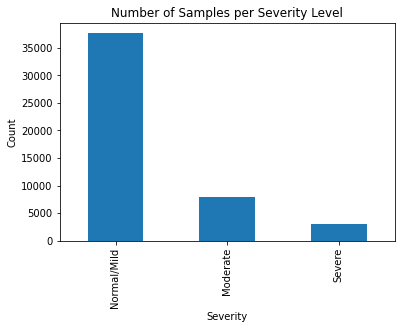

In [26]:
severity_counts.plot(kind='bar')
plt.title('Number of Samples per Severity Level')
plt.xlabel('Severity')
plt.ylabel('Count')
plt.show()

In [ ]:
# datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# train_generator = datagen.flow_from_dataframe(
#     dataframe=merged_df,
#     directory=os.path.join('train_images', str(study_id), str(series_id)),
#     x_col='f"{instance_number}.dcm"',
#     y_col='severity',
#     target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
#     batch_size=BATCH_SIZE,
#     class_mode='categorical',
#     subset='training'
# )

# validation_generator = datagen.flow_from_dataframe(
#     dataframe=merged_df,
#     directory='train/',
#     x_col='Filename',
#     y_col='severity',
#     target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
#     batch_size=BATCH_SIZE,
#     class_mode='categorical',
#     subset='validation'
# )

### Load and Preprocess Images

In [ ]:
def load_and_preprocess_dicom(row):
    dicom_path = os.path.join(
        'train_images',
        str(row['study_id']),
        str(row['series_id']),
        f"{row['instance_number']}.dcm"
    )
    # read the DICOM file
    dicom = pydicom.dcmread(dicom_path)
    image = dicom.pixel_array.astype(np.float32)
    
    # normalize the image (0 to 1)
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    
    # resize the image to 224x224 (VGG16 input size)
    image = tf.image.resize(image, [224, 224]).numpy()
    
    # convert grayscale image to RGB by stacking the grayscale image three times
    image = np.stack((image,)*3, axis=-1)
    
    return image

In [ ]:
# initialize lists to store images and labels
images = []
labels = []

# iterate over the DataFrame and load images
for idx, row in merged_df.iterrows():
    try:
        image = load_and_preprocess_dicom(row)
        images.append(image)
        labels.append(row['severity'])
    except Exception as e:
        print(f"Error loading image for row {idx}: {e}")
        continue

# convert lists to NumPy arrays
images = np.array(images)

In [ ]:
# encode severity labels to integers
severity_mapping = {'Normal/Mild': 0, 'Moderate': 1, 'Severe': 2}
labels_encoded = [severity_mapping[label] for label in labels]
labels_encoded = np.array(labels_encoded)

In [ ]:
# convert labels to categorical (One-Hot Encoding)
labels_categorical = to_categorical(labels_encoded, num_classes=3)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    images,
    labels_categorical,
    test_size=0.2,
    random_state=42,
    stratify=labels_encoded  # Stratify to maintain label distribution
)

In [ ]:
# constants
IMAGE_WIDTH, IMAGE_HEIGHT = 224, 224
BATCH_SIZE = 32

# load the VGG16 model, pretrained on ImageNet without top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

# freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# create the model
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
# train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    shuffle=True,
    batch_size=32,
    epochs=5
)

### Handling class imbalanced data

In [ ]:
from sklearn.utils import class_weight

# compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_encoded),
    y=labels_encoded
)

class_weights_dict = dict(enumerate(class_weights))

# pass class_weights to model.fit()
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32,
    shuffle=True,
    class_weight=class_weights_dict
)

In [ ]:
# evaluate the model
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1])
plt.legend(loc='lower right')

### Fine-Tuning the Base Model

In [ ]:
# unfreeze some layers of the base model
for layer in base_model.layers[-4:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_fine = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32,
    shuffle=True,
    class_weight=class_weights_dict
)

In [ ]:
# Evaluate the model again
plt.plot(history_fine.history['accuracy'], label='accuracy')
plt.plot(history_fine.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.92, 1])
plt.legend(loc='lower right')

### Load data/images in batches during training

In [ ]:
# custom data generator (tf.keras.utils.Sequence) that loads images in batches during training
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, dataframe, batch_size=32, shuffle=True):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.dataframe))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.dataframe) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_df = self.dataframe.iloc[batch_indexes]
        
        images = []
        labels = []
        
        for idx, row in batch_df.iterrows():
            image = load_and_preprocess_dicom(row)
            images.append(image)
            label = severity_mapping[row['severity']]
            labels.append(label)
        
        images = np.array(images)
        labels = to_categorical(labels, num_classes=3)
        return images, labels
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [ ]:
# create training and validation DataFrames
train_df, val_df = train_test_split(merged_df, test_size=0.2, random_state=42, stratify=merged_df['severity'])

# create Data Generators
train_generator = DataGenerator(train_df, batch_size=32, shuffle=True)
val_generator = DataGenerator(val_df, batch_size=32, shuffle=False)

# train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    class_weight=class_weights_dict
)